In [1]:
import json
import os
import numpy as np

In [2]:
def import_metrics_json(models_path, run_num):
    """
    Looks in {models_path}/{run_num}/metrics.json and returns the contents as a
    Python dictionary. Returns None if the path does not exist.
    """
    path = os.path.join(models_path, str(run_num), "metrics.json")
    if not os.path.exists(path):
        return None
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def get_best_metric(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value to use for
    comparison. The best metric value is determined by `metric_compare_func`, which
    must take in two arguments, and return whether or not the _first_ one is better.
    Returns the number of the run, the value associated with that run, and a dict of
    all the values used for comparison.
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_val, all_vals = None, None, {}
    for run_num in metrics.keys():
        try:
            val = reduce_func(metrics[run_num][metric_name]["values"])
            all_vals[run_num] = val
            if best_val is None or compare_func(val, best_val):
                best_val, best_run = val, run_num
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_val, all_vals

In [4]:
def get_best_metric_at_best_epoch(models_path, metric_name, reduce_func, compare_func):
    """
    Given the path to a set of runs, determines the run with the best metric value,
    for the given `metric_name`. For each run, the function `reduce_func` must take
    the array of all values for that metric and return a (scalar) value FOR EACH
    SUBARRAY/VALUE in the value array to use for comparison. The best metric value
    is determined by `metric_compare_func`, which must take in two arguments, and
    return whether or not the _first_ one is better.
    Returns the number of the run, the (one-indexed) number of the epch, the value
    associated with that run and epoch, and a dict of all the values used for
    comparison (mapping pair of run number and epoch number to value).
    """
    # Get the metrics, ignoring empty or nonexistent metrics.json files
    metrics = {run_num : import_metrics_json(models_path, run_num) for run_num in os.listdir(models_path)}
    metrics = {key : val for key, val in metrics.items() if val}  # Remove empties
    
    # Get the best value
    best_run, best_epoch, best_val, all_vals = None, None, None, {}
    for run_num in metrics.keys():
        try:
            # Find the best epoch within that run
            best_epoch_in_run, best_val_in_run = None, None
            for i, subarr in enumerate(metrics[run_num][metric_name]["values"]):
                val = reduce_func(subarr)
                if best_val_in_run is None or compare_func(val, best_val_in_run):
                    best_epoch_in_run, best_val_in_run = i + 1, val
            all_vals[(run_num, best_epoch_in_run)] = best_val_in_run
            
            # If the best value in the best epoch of the run is best so far, update
            if best_val is None or compare_func(best_val_in_run, best_val):
                best_run, best_epoch, best_val = run_num, best_epoch_in_run, best_val_in_run
        except Exception:
            print("Warning: Was not able to compute values for run %s" % run_num)
            continue
    return best_run, best_epoch, best_val, all_vals

In [5]:
def print_validation_profile_and_prior_losses(condition):
    models_path = "/users/amtseng/att_priors/models/trained_models/profile_models/%s/" % condition
    
    print("Best profile loss overall:")
    best_run, best_epoch, best_val, all_vals = get_best_metric_at_best_epoch(
        models_path,
        "val_prof_corr_losses",
        lambda values: np.mean(values),
        lambda x, y: x < y
    )
    print("\tBest run: %s" % best_run)
    print("\tBest epoch in run: %d" % best_epoch)
    print("\tAssociated value: %s" % best_val)
    
    print("Best epoch in each run:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print("\tRun %s, epoch %d: %6.2f" % (key[0], key[1], all_vals[key]))
        
    print("All validation profile and prior losses:")
    for key in sorted(all_vals.keys(), key=lambda p: int(p[0])):
        print(key[0])
        metrics = import_metrics_json(models_path, key[0])
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["train_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.2f" % i for i in np.mean(metrics["val_prof_corr_losses"]["values"], axis=1)]))
        print("\t" + " ".join(["%6.4f" % i for i in np.mean(metrics["val_pos_att_losses"]["values"], axis=1)]))
    return all_vals

In [33]:
noprior_vals = print_validation_profile_and_prior_losses("SPI1")

Best profile loss overall:
	Best run: 5
	Best epoch in run: 10
	Associated value: 87.82174829553675
Best epoch in each run:
	Run 1, epoch 9:  89.65
	Run 2, epoch 10:  90.14
	Run 3, epoch 10:  89.98
	Run 4, epoch 10:  88.26
	Run 5, epoch 10:  87.82
	Run 6, epoch 10:  88.60
	Run 7, epoch 9:  92.54
	Run 8, epoch 10:  92.34
	Run 9, epoch 10:  89.64
	Run 10, epoch 10:  88.97
	Run 11, epoch 10:  88.46
	Run 12, epoch 10:  88.96
	Run 13, epoch 10:  89.30
	Run 14, epoch 10:  88.93
	Run 15, epoch 9:  88.99
	Run 16, epoch 10:  88.51
	Run 17, epoch 10:  88.10
	Run 18, epoch 10:  88.94
	Run 19, epoch 10:  88.30
	Run 20, epoch 10:  88.35
	Run 21, epoch 10:  92.86
	Run 22, epoch 9:  88.46
	Run 23, epoch 10:  90.75
	Run 24, epoch 9:  89.25
	Run 25, epoch 10:  90.65
	Run 26, epoch 9:  90.25
	Run 27, epoch 10:  90.51
	Run 28, epoch 8:  89.11
	Run 29, epoch 9:  89.06
	Run 30, epoch 9:  88.44
	Run 31, epoch 10:  90.10
	Run 32, epoch 10:  88.40
	Run 33, epoch 9:  88.54
All validation profile and prior loss

In [42]:
prior_vals = print_validation_profile_and_prior_losses("SPI1_motifpredprior_attdecay")

Best profile loss overall:
	Best run: 1
	Best epoch in run: 10
	Associated value: 85.51023435239439
Best epoch in each run:
	Run 1, epoch 10:  85.51
	Run 2, epoch 10:  86.55
	Run 3, epoch 4:  86.64
All validation profile and prior losses:
1
	 91.58  88.26  87.59  87.05  86.61  86.34  86.14  86.00  85.87  85.77
	 88.29  87.35  87.01  86.56  86.17  86.09  85.96  85.72  85.63  85.51
	0.8354 0.8356 0.8464 0.8633 0.8729 0.8860 0.8891 0.9019 0.9053 0.9175
2
	 95.44  89.32  88.11  87.26  86.80  86.48  86.26  86.10  85.97  85.86
	 90.58  89.18  88.17  87.43  87.32  86.91  86.80  86.63  86.56  86.55
	0.8381 0.8535 0.8693 0.8713 0.8770 0.8872 0.8941 0.9026 0.9072 0.9157
3
	 93.40  89.25  88.08  87.38
	 89.37  87.95  87.03  86.64
	0.8348 0.8523 0.8541 0.8663


In [13]:
import matplotlib.pyplot as plt

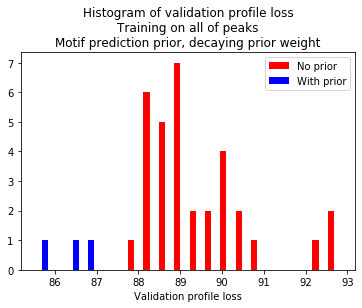

In [44]:
bin_num = 20
plt.figure()
plt.hist(
    [np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))],
    bin_num, histtype="bar",
    label=["No prior", "With prior"], color=["red", "blue"])
title = "Histogram of validation profile loss"
title += "\nTraining on all of peaks"
title += "\nMotif prediction prior, decaying prior weight"
plt.title(title)
plt.xlabel("Validation profile loss")
plt.legend()

In [36]:
np_vals, p_vals = np.array(list(noprior_vals.values())), np.array(list(prior_vals.values()))

In [23]:
import scipy.stats

In [37]:
t, p = scipy.stats.ttest_ind(np_vals, p_vals)
print(t)
print(p / 2)

0.48643477861338436
0.3142620175292996
